# Problem 2

In this part, we train a Variational Auto-Encoder  (VAE) on the binarized MNIST dataset. The VAE is a probabilistic graphical model based on Bayesian inference. It is composed of an encoder network that, given an example, outputs the parameters of a multidimensional normal distribution used to sample the corresponding latent variables. Then, these latent variables are fed to a decoder network that outputs a reconstruction of the input example.

Our VAE model is trained to create a 100-dimensional smooth latent embedding of the binarized MNIST dataset.

In [0]:
# Mount the virtual drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd gdrive/My\ Drive/AaronTP3

/content/gdrive/My Drive/AaronTP3


In [0]:
# Import useful libraries:

import torch
import copy
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch import nn
from torch import optim
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm

# select device:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
print(device)

cuda:0


### Data Generator

In [0]:
# Dataset class

class BMDataset(Dataset):
  
  def __init__(self, path):
      self.f = list(open(path))
      # Convert values into float & reshape into 28x28
      self.data = torch.tensor([np.array(list(map(lambda x:float(x),instan.split()))) for instan in self.f]).reshape(-1,28,28).unsqueeze(1).float()
  def __len__(self):
      return len(self.f)

  def __getitem__(self, index):
      data = self.data[index]
      return data

### Data Loader

In [0]:
# Load binarized MNIST

def get_data_loader(batch_size=1, num_workers=1, shuffle=False):

    trainpath = "binarized_mnist/binarized_mnist_train.amat"
    validpath = "binarized_mnist/binarized_mnist_valid.amat"
    testpath = "binarized_mnist/binarized_mnist_test.amat"
    
    trainset = BMDataset(trainpath)
    validset = BMDataset(validpath)
    testset = BMDataset(testpath)

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers
    )

    validloader = torch.utils.data.DataLoader(
        validset,
        batch_size=batch_size,
    )

    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=batch_size,
    )

    return trainloader, validloader, testloader

In [0]:
# get dataloaders:

trainloader, validloader, testloader = get_data_loader(batch_size=10, num_workers=2)

# Training the VAE :

### Model

In this section we implement our VAE model.

The reparametrization trick is used in the sample_latent function. Its purpose is to allow for gradients backpropagation through the bottleneck of the VAE (i.e. the part where the latent variables **z** are sampled).

Indeed, if we didn't use this trick, we would directly sample the $z_i$ in $\mathcal{N}(\mu_i,\sigma_i)$. Instead, we sample the $e_i$ in $\mathcal{N}(0,1)$ and compute the $z_i$ as:
$$
z_i = \mu_i + \sigma_i \odot e_i
$$
which converts **z** from a random node to a deterministic node (the random node is now **e**).

In [0]:
# VAE model

class VAE(nn.Module):
  
  def __init__(self):
    super(VAE, self).__init__()
    # Encoder
    self.encoder = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
      nn.ELU(), # amortized ReLU
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4),
      nn.ELU(),
      nn.AvgPool2d(kernel_size=2, stride=2), 
      nn.Conv2d(in_channels=64, out_channels=256, kernel_size=5),
      nn.ELU()
    )
    
    # Bottleneck
    self.fcEncoder = nn.Linear(in_features=256, out_features=200) # outputs mu and sigma
    self.fcDecoder = nn.Sequential(
      nn.Linear(in_features=100, out_features=256),
      nn.ELU()
    )
        
    # Decoder
    self.decoder = nn.Sequential(
      nn.Conv2d(in_channels=256, out_channels=64, kernel_size=5, padding=4),
      nn.ELU(),
      nn.UpsamplingBilinear2d(scale_factor=2),
      nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=2),
      nn.ELU(),
      nn.UpsamplingBilinear2d(scale_factor=2),
      nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=2),
      nn.ELU(),
      nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=2),
    )
    
    # To output probabilities between 0 & 1 since the data is binarized
    self.sigmoid = nn.Sigmoid()
  
  def encode(self, x):
    x = self.encoder(x)
    x = x.view(x.size(0), 256)
    q_params = self.fcEncoder(x) # Size 200
    mu, logvar = q_params[:, :100] , q_params[:, 100:] # Mean & log(Variance)
    self.mu, self.logvar = mu, logvar # to access these after the forward pass
    return mu, logvar
  
  def sample_latent(self, mu, logvar):
    # reparametrization trick:
    sigma = logvar.mul(0.5).exp() # multiply logvar by 0.5 is equivalent to doing log(sqrt of var)
    self.sigma = sigma # Variance
    e = torch.randn(mu.size(0), 100).to(device) # Random samples from the N(0,1) distribution
    z = mu + sigma * e 
    return z
  
  def decode(self, z):
    x_hat = self.fcDecoder(z)
    x_hat = x_hat.view(z.size(0), 256, 1, 1)
    return self.sigmoid(self.decoder(x_hat)) # Apply sigmoid on the output
  
  def forward(self, x):
    mu, log_var = self.encode(x) # encode to compute mean and log variance
    z = self.sample_latent(mu, log_var) # sample a latent variable from mean and log variance
    return self.decode(z) # decode latent variable
  
  def train_model(self, lr = 0.0003, epochs = 20):
    optimizer = optim.Adam(self.parameters(), lr = lr)
    running_loss = 0
    train_losses, train_bces, train_klds, valid_losses, valid_bces, valid_klds = [], [], [], [], [], []
    for epoch in tqdm(range(epochs)):
      running_loss = 0
      running_bce = 0
      running_kld = 0
      for inputs in trainloader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        logps = self.forward(inputs)
        loss,bce,kld = negative_ELBO(logps, inputs, self.mu, self.logvar)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_bce += bce.item()
        running_kld += kld.item()
        #break
      valid_loss = 0
      valid_bce = 0
      valid_kld = 0
      accuracy = 0
      self.eval()
      with torch.no_grad():
        for inputs in validloader:
          inputs = inputs.to(device)      
          logps = self.forward(inputs)
          loss, bce, kld = negative_ELBO(logps, inputs, self.mu, self.logvar)
          valid_loss += loss.item()
          valid_bce += bce.item()
          valid_kld += kld.item()
      train_losses.append(running_loss/len(trainloader))
      train_bces.append(running_bce/len(trainloader))
      train_klds.append(running_kld/len(trainloader))
      valid_losses.append(valid_loss/len(validloader))
      valid_bces.append(valid_bce/len(validloader))
      valid_klds.append(valid_kld/len(validloader))
      print(f"Epoch {epoch+1}/{epochs}.. "
            f"Train ELBO: {-running_loss/len(trainloader):.3f} "
            f"Validation ELBO: {-valid_loss/len(validloader):.3f}")
      self.train()
    return train_losses, train_bces, train_klds, valid_losses, valid_bces, valid_klds

### Loss

We know that the ELBO is a lower bound for the marginal log likelihood of the data. Our goal is then to maximize the ELBO, so we maximize the marginal log likelikhood as a side effect. In this section, we compute the **negative** ELBO.

Since we want to maximize the ELBO, we should minimize its negative value, hence use it as a loss function for gradient descent.

In [0]:
# negalive ELBO

def negative_ELBO(x_hat, x, mu, log_var):
    batch_size = x.shape[0]
    BCE = F.binary_cross_entropy(x_hat, x, reduction = "sum") / batch_size # (sum over pixels of each instance, mean over batch) 
    KLD = 0.5 * torch.sum(- 1 - log_var + mu.pow(2) + log_var.exp()) / batch_size# (sum over pixels of each instance, mean over batch)
    # ELBO = - BCE - DKL

    return BCE + KLD, BCE, KLD

Let us look at the reconstruction of an input before training the VAE model. For instance, let us select the folowing input:

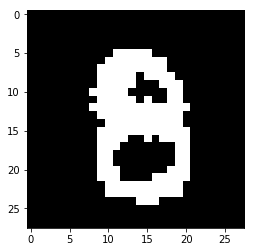

In [0]:
# Select an input

x = next(iter(trainloader))
x = x.to(device)
plt.imshow(x[2,0].detach().cpu(), "gray")

In [0]:
# Model
vae = VAE()
vae = vae.to(device)

In [0]:
# Output
x_hat = vae.forward(x)

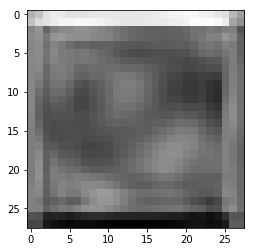

In [0]:
# Forward pass - Reconstruction

x_hat = vae.forward(x)
plt.imshow(x_hat.detach().cpu().numpy()[2,0], "gray")

The output of the untrained network is of course random, however we observe some regularities in the output image. It would be interesting to further understand where they come from, but we guess this is a natural effect of random convolutional layers. Let us now train our VAE model:

### Training

In [0]:
train_losses, train_bces, train_klds, valid_losses, valid_bces, valid_klds = vae.train_model()

Epoch 1/20.. Train ELBO: -137.442 Validation ELBO: -112.074
Epoch 2/20.. Train ELBO: -107.260 Validation ELBO: -105.221
Epoch 3/20.. Train ELBO: -102.537 Validation ELBO: -101.424
Epoch 4/20.. Train ELBO: -100.049 Validation ELBO: -99.512
Epoch 5/20.. Train ELBO: -98.542 Validation ELBO: -98.652
Epoch 6/20.. Train ELBO: -97.417 Validation ELBO: -97.547
Epoch 7/20.. Train ELBO: -96.566 Validation ELBO: -96.555
Epoch 8/20.. Train ELBO: -95.913 Validation ELBO: -96.211
Epoch 9/20.. Train ELBO: -95.389 Validation ELBO: -95.534
Epoch 10/20.. Train ELBO: -94.913 Validation ELBO: -94.966
Epoch 11/20.. Train ELBO: -94.503 Validation ELBO: -95.755
Epoch 12/20.. Train ELBO: -94.243 Validation ELBO: -94.448
Epoch 13/20.. Train ELBO: -93.915 Validation ELBO: -94.448
Epoch 14/20.. Train ELBO: -93.678 Validation ELBO: -94.246
Epoch 15/20.. Train ELBO: -93.414 Validation ELBO: -93.708
Epoch 16/20.. Train ELBO: -93.189 Validation ELBO: -94.132
Epoch 17/20.. Train ELBO: -93.024 Validation ELBO: -93.969

Our validation ELBO after 20 epoch is $\sim$ -93.6

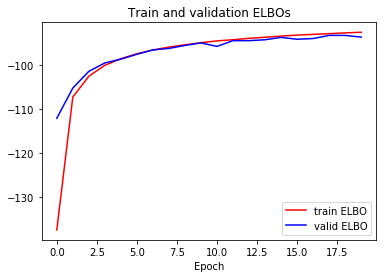

In [0]:
plt.figure()
plt.plot(-1 * np.array(train_losses), 'r', label="train ELBO")
plt.plot(-1 * np.array(valid_losses), 'b', label="valid ELBO")
plt.title("Train and validation ELBOs")
plt.xlabel("Epoch")
plt.legend()

plt.show()

After 20 epochs, our model doesn't seem to have overfitted yet. We could train it a bit more but we will instead look at the results after this amount of training.

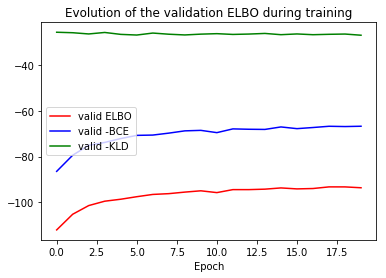

In [0]:
plt.figure()
plt.plot(-1*np.array(valid_losses), 'r', label="valid ELBO")
plt.plot(-1*np.array(valid_bces), 'b', label="valid -BCE") 
plt.plot(-1*np.array(valid_klds), 'g', label="valid -KLD")
plt.title("Evolution of the validation ELBO during training")
plt.legend()
plt.xlabel("Epoch")
plt.show()

By decomposing the training curves, we notice that the negative KL-divergence stayed roughly constant during training while the negative reconstruction loss increased. Actually, the negative KL even slightly decreased, which shows that the model used it as a regularizer (constraint) rather than the first quantity to optimize, which is the reconstruction loss. The best achieved validation ELBO during training is reported below:

In [0]:
print("The best ELBO is ",-np.min(valid_losses))

The best ELBO is  -93.25274557495118


Let us look at the reconstruction of the same input after training the VAE model:

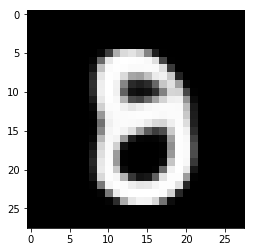

In [0]:
# Forwad pass - Reconstruction

x_hat = vae.forward(x)
plt.imshow(x_hat.detach().cpu().numpy()[2,0], "gray")

The reconstructed image is smooth because we keep the probabilities here. Interestingly, doing so allows us to obtain an image that looks more natural than the binarized input.

# Evaluating log-likelihood with Variational Autoencoders:

### Importance sampling

Importance sampling is a Monte Carlo algorithm that allows us to estimate the log likelihood of our data.

In [0]:
import torch.distributions.normal as tn

def importance_samples(model, examples_array, latents_array=None, nb_samples=200, eps = 1.0e-8):
  """
  model: a VAE model
  examples_array: an array of size (dim_minibatch * dim_example)
  latents_array: (deprecated: use nb_samples instead) an array of size (dim_minibatch * nb_samples * dim_latent)
  nb_samples: the number of latent variable samples that need to be generated. This is overidden if latents_array is provided
  """
  
  if latents_array:
    nb_samples = latents_array.shape[1]
  
  dim2d = np.sqrt(examples_array.shape[1])
  assert dim2d.is_integer(), "The second dimension of examples_array is not a square"
  dim2d = int(dim2d)
  
  with torch.no_grad():
    
    examples_array = examples_array.view(examples_array.shape[0], 1, dim2d, dim2d)
    # Forward
    output = model(examples_array)
    # Mean & Log variance & Variance
    mu = model.mu
    logvar = model.logvar
    sigma = model.sigma
    # Empty tensors for latent samples 
    latents_array = torch.zeros(size=(mu.size(0), mu.size(1), nb_samples))
    latents_array = latents_array.to(device)
    # Empty tensors for outputs
    out_array = torch.zeros(size=(examples_array.shape[0], 1, dim2d, dim2d, nb_samples))
    out_array = out_array.to(device)
    # Generate samples
    for i in range(nb_samples):
      # Generate samples from the N(0,1) distribution
      e = torch.randn(mu.size(0), mu.size(1)).to(device)
      # Reparametrization
      z = mu + sigma * e
      # Store the sample
      latents_array[...,i] = z
      # Store the output decoded from the sample
      out_array[...,i] = model.decode(z)
    
    # Density of latent variables 
    q_phi = tn.Normal(mu.view(mu.shape[0],mu.shape[1],1), sigma.view(sigma.shape[0],sigma.shape[1],1))
    logq_phi = q_phi.log_prob(latents_array)
    # Sum log over the dim 1 (100)
    logq_phi = torch.sum(logq_phi, dim=1)
    # The prior
    p = tn.Normal(0, 1) 
    logp = p.log_prob(latents_array)
    # sum log over the dim 1 (100)
    logp = torch.sum(logp, dim=1)
    # Use binary cross entropy to get the density of the output
    examples_array = examples_array.unsqueeze(-1)
    logp_theta = -F.binary_cross_entropy(out_array, examples_array.expand(*examples_array[...,0].size(),nb_samples), reduction="none")
    assert out_array.shape[1] == 1, "Unexpected output dimension for the decoder"
    # sum over the dim 1 (1), 2 (28) & 3 (28)
    logp_theta = torch.sum(logp_theta, dim=(1,2,3))
    # Compute log(p_theta*p/q_phi)
    log_quotient = logp_theta + logp - logq_phi
    # Compute the log likelihood
    log_likelihood = -np.log(nb_samples) + torch.logsumexp(log_quotient, dim=1) 
    
    return log_likelihood, output, mu, logvar

In [0]:
# Take a batch from the train loader
xs =next(iter(trainloader)).to(device)
# reshape
xs = xs.view(xs.shape[0], xs.shape[2] * xs.shape[3])

log_likelihood, output, mu, logvar = importance_samples(vae, xs)

print("Log likelihood: ",log_likelihood)

Log likelihood:  tensor([-111.8619,  -61.7234,  -86.2730,  -90.0585, -101.4648,  -49.5883,
         -81.3943,  -73.9462,  -95.0270,  -38.0009], device='cuda:0')


### ELBO vs Log Likelihood

In [0]:
def elbo_vs_estimloglike(loader):
    
    cumul_negative_elbo = 0
    
    cumul_log_likelihood = 0
    
    c = 0 
    for data in tqdm(loader):
        
        data = data.to(device)
        data = data.view(data.shape[0], data.shape[2] * data.shape[3])
        # Calculate the log likelihood of the batch
        log_likelihood, output, mu, logvar = importance_samples(vae, data)
        # Calculate the negative elbo of the batch
        negative_elbo,_,_ = negative_ELBO(output, data, mu, logvar)
        
        cumul_negative_elbo += negative_elbo.item()/len(loader)
        cumul_log_likelihood += torch.mean(log_likelihood).item()/len(loader)
        
    # Average Elbo & Log likelihood
    print("elbo = ", -(cumul_negative_elbo))
    print("estimated log likelihood= ",(cumul_log_likelihood))

In [0]:
print("For Validation set: ")
elbo_vs_estimloglike(validloader)
print("\n")
print("For Test set: ")
elbo_vs_estimloglike(testloader)

For Validation set: 



elbo =  -93.70895540618899
estimated log likelihood=  -87.64254882812486


For Test set: 



elbo =  -93.15063550186154
estimated log likelihood=  -87.07505219268799


On both validation and test set, our ELBO is smaller than out estimated log likelyhood. This illustrates the fact that the ELBO is a lower bound for the true log likelihood.

# Playing around with the latent embedding:

Let us now explore the quality of our embedding. We take two random inputs and compute a transition from one to another.

In [0]:
# get new dataloaders:
trainloader, validloader, testloader = get_data_loader(batch_size=2, num_workers=2, shuffle=False)

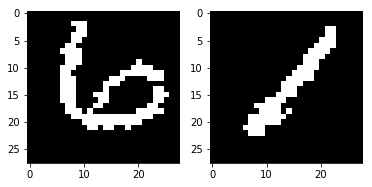

In [0]:
x = next(iter(trainloader))

x = x.to(device)

plt.subplot(121)
plt.imshow(x[0,0].detach().cpu(), "gray")
plt.subplot(122)
plt.imshow(x[1,0].detach().cpu(), "gray")

Let us get the latent variables of these two inputs

In [0]:
mus, logvars = vae.encode(x)
zs = vae.sample_latent(mus, logvars)

We then perform an interpolation between the two latent embeddings of our inputs:

In [0]:
interp_z = torch.zeros(10, zs.shape[1])

# Interpolation
for i in range(interp_z.shape[0]):
    interp_z[i] = zs[0] + ((i+1)/interp_z.shape[0])*(zs[1] - zs[0])

Now let us look at the ouputs of our interpolated latent embeddings:

In [0]:
interp_z = interp_z.to(device)
out = vae.decode(interp_z)

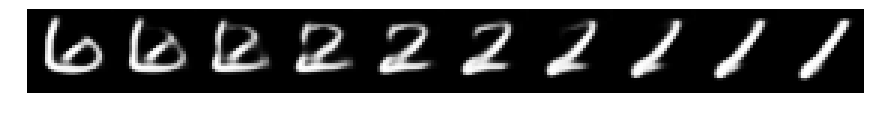

In [0]:
fig, axs = plt.subplots(1,10, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(10):

    axs[i].imshow(out[i,0].detach().cpu(), "gray")
    axs[i].axis("off")

The transition looks very smooth! Indeed, using the KL-Divergence with a prior standard normal distribution as a regularizer for our loss function, we forced the embedding space to be close to the origin. Since we have furthermore used a random strategy to generate the latent variables, the regularization helped generate a dense embedding space, with smooth transitions from one cluster to another. Interestingly, the interpolation in the latent space crossed a latent cluster of $2$ to make a smooth transition from a cluster of $6$ to a cluster of $1$.